In [1]:
from collections import defaultdict
import dill
import glob
import warnings
warnings.filterwarnings('always')

from tools.text_process import SpacyLemmaTokenizer
from tools.image_process import LayerName, getLayerNames
from tools.instance import Node
from tools.containers import Picture, Description
from tools.knowledge import LayerBase, TextBase
from tools.common import ravel

from models.encoder import TextPictureRavelEncoder

/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/dongjustin/miniconda2

/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [2]:
layerbase = LayerBase()
print(layerbase.index(Node('man','subj')))

textbase = TextBase()
len(textbase.vocab_)#index('man','n')
# textbase.vocab_

50


75

In [3]:
img_dir='images'
txt_dir='text'
name = 'Firmware'

description = Description('%s/%s.txt' % (txt_dir, name))
picture = Picture('%s/%s.svg' % (img_dir, name))
print(picture)
description

#background; #alien(have[robot],stand); #man(exercise,step_on[stone]); #man(work,play[computer],sit)


A man played the computer. A man stepped on the stone and exercised. They had a robot.

In [4]:
encoder = TextPictureRavelEncoder()
vec = encoder.encode(description, picture)#.toarray()
vec.shape

 - Initiate layer base..
 - Initiate text base..
 - Load relatedness dict..
 - Initiate scaler..
 - List feature names..


(505,)

In [5]:
class Dataset():
    def __init__(self, img_dir='images',
                       txt_dir='text',
                       names=[]):
        
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        self.names = names # specify training data

        print(' - Initialize encoder..')
        self.encoder = Encoder(names=names)
        self.features_ = self.encoder.features_

    def _get_pair(self, txt_name=None, img_name=None,
                        ran_txt=False, ran_img=False,
                        fake_img=False):
        ##### preprocess
        ## text
        assert txt_name
        doc = Description(txt_name)
            
        if ran_txt:
            # make sure random chosen doc are different
            while True:
                ran_doc = random.choice(list(self.encoder.textbase.doc_vocab_))
                if ran_doc != doc:
                    break
            doc = ran_doc
        else:
            # use true doc
            pass
        
        ## image
        assert img_name
        pic = Picture(img_name)
        
        if ran_img:
            # then choose one from all unique pictures
            assert not fake_img
            
            # make sure random chosen pic are different
            while True:
                ran_pic = random.choice(list(self.encoder.layerbase.pic_vocab_))
                if ran_pic != pic:
                    break
            pic = ran_pic
            
        elif fake_img:
            # then choose several unique layers
            assert not ran_img
            
            # make sure random chosen pic are different
            while True:
                # randomly choose 1 - 5 layers
                num_layers = random.choice(range(1,6))
                ran_layers = []
                for _ in range(num_layers):
                    ran_layers.append(random.choice(list(self.encoder.layerbase.layer_vocab_)))
                ran_pic = Picture(layernames=[l.s for l in ran_layers])
                if ran_pic != pic:
                    break
            pic = ran_pic                
        else:
            # use true pic
            pass

        return doc, pic

    def encode(self, doc, pic):
        return self.encoder.encode(doc, pic)

    def __getitem__(self, name):
        img_name = '%s/%s.svg' % (self.img_dir, name)
        txt_name = '%s/%s.txt' % (self.txt_dir, name)

        # assert((layers and sent) or (not layers and not sent)), 'layers and sentence must be provided together, or neither'

        # get layers
        # if not layers and not sent:
        #     layers, sent = self.getOneLayerSent(**kwargs)

        # triplets
        triplets = []
        triplets_pair = []

        # true match
        doc, pic = self._get_pair(txt_name=txt_name,
                                  img_name=img_name)
        triplets_pair.append((doc, pic))
        # print('- encode true pairs..')
        triplets.append(self.encode(doc, pic))


        # mismatched text
        doc, pic = self._get_pair(txt_name=txt_name,
                                      img_name=img_name,
                                      ran_txt=True)
        triplets_pair.append((doc, pic))
        # print('- encode true pic and ran doc..')
        triplets.append(self.encode(doc, pic))

        # mismatched image
        doc, pic = self._get_pair(txt_name=txt_name,
                                      img_name=img_name,
                                      ran_img=True)
        triplets_pair.append((doc, pic))
        # print('- encode true doc and ran pic..')
        triplets.append(self.encode(doc, pic))
    
        # fake image
        # triplets.append(self.encode(txt_name=txt_name,
        #                             fake_img=True))

        # concatenate
        xs = np.vstack(triplets)
        ys = np.array([1,0,0]).reshape(-1,1)

        return sparse.csr_matrix(np.hstack([xs, ys])), triplets_pair

    def getFakeLayers(self):
        pass
        return ranGenLayer()

    def __len__(self):
        # return len(glob.glob(self.img_dir+'/*.svg'))
        # return len(list(getOrderedList(self.img_dir+'/*.svg')))
        # return len(list(getFiles(self.img_dir, ext='.svg', index=self.index)))
        return len(self.names)


In [577]:
dataset = Dataset()
dataset['Fireworks']

 - Initialize encoder..
 - Initiate layer base..
 - Initiate text base..
 - Load relatedness dict..
 - Initiate scaler..
- encode true pairs..
 -- gen sparse..
 -- scale..
 -- gen hists..
- encode true pic and ran doc..
 -- gen sparse..
 -- scale..
 -- gen hists..
- encode true doc and ran pic..
 -- gen sparse..
 -- scale..
 -- gen hists..


(<3x506 sparse matrix of type '<class 'numpy.int64'>'
 	with 54 stored elements in Compressed Sparse Row format>,
 [(Two women enjoyed fireworks in the wild.,
   #background; #woman(stand,talk); #woman(point_to,show,stand); #wild(have[firework,plant])),
  (A man is standing and a woman is sitting with a computer to transfer money.,
   #background; #woman(stand,talk); #woman(point_to,show,stand); #wild(have[firework,plant])),
  (Two women enjoyed fireworks in the wild.,
   #background; #woman(sit_on[chair]))])

In [6]:
import re
import random
from sklearn.linear_model import LogisticRegression
from ana.visual import STAT, ROC, FEAT
random.seed(7)
np.random.seed(7)

class Pipeline:
    def __init__(self):
        print(' ------ train test split -------')
        self.train_names, self.test_names = self.train_test_split()
        # assert('Frozen' in self.train_names)
        
        print(' ------ build dataset -------')
        self.dataset = Dataset(names=self.train_names)
        
        print(' ------ gather data -------')
        
        # self.train_set, self.test_set = 
        self.build_data(self.train_names,self.test_names)
#         print(' ------ train classifier -------')
#         self.clf = self.train_classifier(self.train_set)
#         self.evaluate(sel.clf, self.train_set, self.test_set)
    
    def _get_root(self, path):
        return re.findall(r'\/(\w+)\.', path)[0]
    
    def train_test_split(self, test_r=0.2, shuffle=True):
        names = [self._get_root(path) for path in glob.glob('images/*.svg')]
        names_ = [self._get_root(path) for path in glob.glob('text/*.txt')]
        
        # names must be unique
        assert(len(names) == len(set(names)))
        # names from both sides must be identical
        assert(set(names) == set(names_))
        
        if shuffle:
            random.shuffle(names)
        
        ind = int(len(names) * (1-test_r))
        
        return names[:ind], names[ind:]
    
    def __fetch_data(self, names):
        data = []
        pairs = []
        for c, name in enumerate(names):
            print('    Fetching: [%i] - %s' % (c, name), end='\r')
            vec, pair = self.dataset[name]
            data.append(vec)
            pairs.extend(pair)
        print('     Fetched: [%i]' % (c+1))
        data = sparse.vstack(data)
        return data, pairs
    
    def build_data(self, train, test):
#         train_set = []
#         train_pairs = []
#         for name in train:
#             print('     ------ Fetching [%s]' % name,
#                   end='\r')
#             vec, pair = self.dataset[name]
#             train_set.append(vec)
#             train_pairs.append(pair)
        
        print(' -------------- train set ---------------- ')
        self.train_set, self.train_pairs = self.__fetch_data(train) # np.vstack(train_set)
        
        print(' -------------- test set ---------------- ')
        # test_set = np.vstack([self.dataset[name] for name in test])
        self.test_set, self.test_pairs = self.__fetch_data(test)
        # return train_set, test_set
        # return None, None
    
    def train_classifier(self, train_set, class_weight={1: 1, 0: 0.1}, C=1.0):
        clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         class_weight=class_weight,
                         penalty='l1',
                         C=C,
                         max_iter=100)
        
        clf.fit(train_set[:,:-1],
                train_set[:,-1].toarray().flatten())
        return clf
    
    def evaluate(self, clf, train_set, test_set):
        print('------- train ---------')
        y_true = train_set[:,-1].toarray().flatten()
        y_prob = clf.predict_proba(train_set[:,:-1])[:,1]
        STAT(y_true, y_prob, path='STAT_%s' % suffix)
        
        print('------- test ---------')
        y_true = test_set[:,-1].toarray().flatten()
        y_prob = clf.predict_proba(test_set[:,:-1])[:,1]
        STAT(y_true, y_prob, path='STAT_%s' % suffix)

In [7]:
### it's ok to have layerbase cover all the pictures
### because pictures are made from our layer base anyway
### not like text can type arbitraily

### 1.0: categories are fixed, thus no way there's an unseen category

In [8]:
pipeline = Pipeline()

 ------ train test split -------
 ------ build dataset -------
 - Initialize encoder..
 - Initiate layer base..
 - Initiate text base..
 - Load relatedness dict..
 - Initiate scaler..
 - List feature names..
 ------ gather data -------
 -------------- train set ---------------- 
     Fetched: [32] - track_and_field
 -------------- test set ---------------- 


/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! fish(VERB)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! lake(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! fish(VERB)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! lake(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! snowman(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: No word in "There is a snowman." are seen. Returned zero matrix.


/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! snowman(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: No word in "There is a snowman." are seen. Returned zero matrix.


/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! drone(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! drone(NOUN)


/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! windmill(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! windmill(NOUN)


/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! gamepad(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! gamepad(NOUN)
/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! think(VERB)


     Fetched: [8] - Forgot_password


/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Unseen word encountered! think(VERB)


In [9]:
pipeline.test_pairs

[(A woman is playing with her computer next to a web page.,
  #background; #other(have[website]); #wild(have[leaf]); #woman(sit,watch,play[computer])),
 (A woman is sitting on the clouds and the sun.,
  #background; #other(have[website]); #wild(have[leaf]); #woman(sit,watch,play[computer])),
 (A woman is playing with her computer next to a web page.,
  #background; #wild(have[plant]); #other(have[gamepad]); #man(touch,stand)),
 (A man is fishing on the lake.,
  #background; #wild(have[lake,hill,cloud]); #wild(have[boat]); #man(fishing,stand,hold[fishing_rod])),
 (A woman is sitting at her desk.,
  #background; #wild(have[lake,hill,cloud]); #wild(have[boat]); #man(fishing,stand,hold[fishing_rod])),
 (A man is fishing on the lake.,
  #background; #chart(have[list]); #woman(stand,present)),
 (There is a snowman., #alien(have[snowman])),
 (A man is standing against the camera., #alien(have[snowman])),
 (There is a snowman.,
  #background; #other(have[website]); #wild(have[leaf]); #woman(si

In [10]:
def train_classifier(train_set, class_weight={1: 1, 0: 0.1}, C=1.0):
    clf = LogisticRegression(# random_state=0,
                     solver='liblinear',
                     class_weight=class_weight,
                     penalty='l1',
                     C=C,
                     max_iter=100)

    clf.fit(train_set[:,:-1],
            train_set[:,-1].toarray().flatten())
    return clf

def evaluate(clf, pipeline, save=False, suffix='temp'):
    print('------- train ---------')
    y_true = pipeline.train_set[:,-1].toarray().flatten()
    y_prob = clf.predict_proba(pipeline.train_set[:,:-1])[:,1]
    STAT(y_true, y_prob, path='STAT_%s' % suffix)

    print('------- test ---------')
    y_true = pipeline.test_set[:,-1].toarray().flatten()
    y_prob = clf.predict_proba(pipeline.test_set[:,:-1])[:,1]
    STAT(y_true, y_prob, path='STAT_%s' % suffix)
    
    ROC(y_true, y_prob, path='ROC_%s' % suffix)
    
    FEAT(pipeline.dataset, clf, path='FEAT_%s' % suffix, top=20)
    

------- train ---------
32 positives out of 96 test examples
Overall accuracy: 0.739583
*Recall(thresh=0.5)/AccuracyOf1: 0.968750
Precision(thresh=0.5): 0.563636
AccuracyOf0(thresh=0.5): 0.739583
------- test ---------
8 positives out of 24 test examples
Overall accuracy: 0.750000
*Recall(thresh=0.5)/AccuracyOf1: 0.750000
Precision(thresh=0.5): 0.600000
AccuracyOf0(thresh=0.5): 0.750000
precision | recall | F1 | threshold
------------------------------
0.571 | 1.000 | 0.727 | 0.462
0.538 | 0.875 | 0.667 | 0.486
0.583 | 0.875 | 0.700 | 0.500
0.600 | 0.750 | 0.667 | 0.613
0.667 | 0.750 | 0.706 | 0.646
0.625 | 0.625 | 0.625 | 0.664
0.571 | 0.500 | 0.533 | 0.666
0.667 | 0.500 | 0.571 | 0.666
0.500 | 0.250 | 0.333 | 0.675
0.667 | 0.250 | 0.364 | 0.675
1.000 | 0.250 | 0.400 | 0.696
1.000 | 0.125 | 0.222 | 0.709
------------------------------


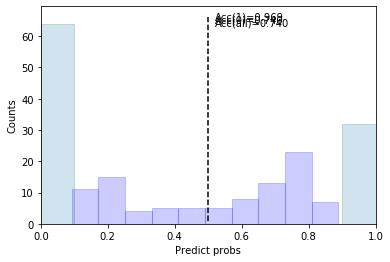

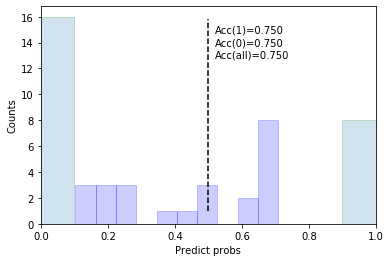

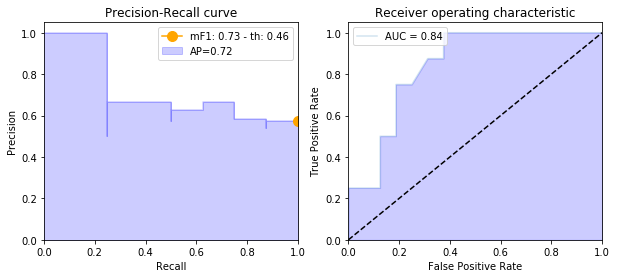

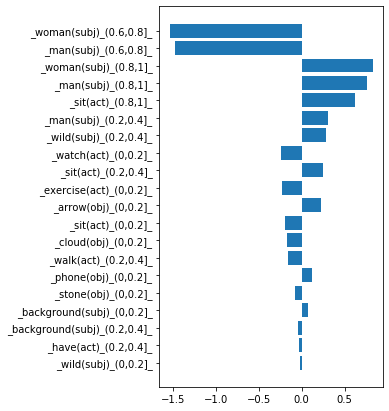

In [11]:
clf = train_classifier(pipeline.train_set, class_weight={1: 1, 0: 0.3}, C=1)
evaluate(clf, pipeline)

In [401]:
from collections import Counter
print(len(layerbase.layer_vocab_))
c = Counter(layerbase.layer_vocab_)
for layer, count in c.most_common():
    if count <= 1: break
    print(ravel(layer.entities_), count)
"""
layer keywords
then fetch these contain the tokens in the transformed(to keyword) description

how?
for each keyword, fetch a layer?
"""

82


'\nlayer keywords\nthen fetch these contain the tokens in the transformed(to keyword) description\n\nhow?\nfor each keyword, fetch a layer?\n'

### generator

In [8]:
import spacy
# from spacy.pipeline import Tagger
nlp = spacy.load("en_core_web_sm")
# tagger = Tagger(nlp.vocab)
# tagger = nlp.create_pipe("tagger")
# tagger(
doc = nlp(u'A joyful man plays computer frequently and sits on the ground')
for token in doc:
    print(token.i, token.text, token.tag_, token.is_stop)


0 A DT True
1 joyful JJ False
2 man NN False
3 plays VBZ False
4 computer NN False
5 frequently RB False
6 and CC True
7 sits VBZ False
8 on IN True
9 the DT True
10 ground NN False


In [10]:
token.is_space

False

In [72]:
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
token = nlp('ducks')
lemmas = lemmatizer(u"ducks", u"adjective")
# assert lemmas == [u"duck"]
type(token)

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'lower'

In [134]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(u'A man plays computer and hits the ground. A woman is waving.')
for token in doc:
    print("{2}({3}-{6}, {0}:{1}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))

det(man-2, A:DT-1)
nsubj(plays-3, man:NN-2)
ROOT(plays-3, plays:VBZ-3)
dobj(plays-3, computer:NN-4)
cc(plays-3, and:CC-5)
conj(plays-3, hits:VBZ-6)
det(ground-8, the:DT-7)
dobj(hits-6, ground:NN-8)
punct(plays-3, .:.-9)
det(woman-11, A:DT-10)
nsubj(waving-13, woman:NN-11)
aux(waving-13, is:VBZ-12)
ROOT(waving-13, waving:VBG-13)
punct(waving-13, .:.-14)


In [409]:
# doc = nlp(u'A man and a man play computer on the ground. A woman is waving.')
# doc = nlp(u'There is a tree and some plants in the park')
doc = nlp(u'A man is lying on the sofa watching the movie') # xcomp
for token in doc:
    print("{2}({3}-{6}, {0}:{1}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))

det(man-2, A:DT-1)
nsubj(lying-4, man:NN-2)
aux(lying-4, is:VBZ-3)
ROOT(lying-4, lying:VBG-4)
prep(lying-4, on:IN-5)
det(sofa-7, the:DT-6)
pobj(on-5, sofa:NN-7)
advcl(lying-4, watching:VBG-8)
det(movie-10, the:DT-9)
dobj(watching-8, movie:NN-10)


In [275]:
list(list(list(doc.sents)[0].root.children)[1].children)

[a, and, plants, in]

In [285]:
if list(doc.sents)[0].root.children:
    print(1)

1


In [152]:
list(list(doc[9].children)[0].children)

[ground]

In [142]:
[list(sent.root.children) for sent in doc.sents]

[[man, are, computer, and, sits, .], [woman, is, .]]

In [154]:
## entities detection
list(doc.ents)
## sentences
print(list(doc.sents))
print([s.root.text for s in doc.sents])


## sentencizer # this would be sufficient for current ravel similarity
doc = nlp(u'A man and a man are playing computer and sitting on the ground. A woman is waving.')
keywords = []
for s in doc.sents:
    keywords.append([t.lemma_ for t in s if t.pos_ in ['VERB', 'NOUN'] and not t.is_stop])
print(keywords)

[A man and a man are playing computer and sitting on the ground., A woman is waving.]
['playing', 'waving']
[['man', 'man', 'play', 'computer', 'sit', 'ground'], ['woman', 'wave']]


In [160]:
re.match(r'\w+obj','dobj')

<re.Match object; span=(0, 4), match='dobj'>

In [297]:
def recur_search_children(root, dep_r=r'\w*obj',
                                pos_r=r'.*',
                                skip_conj=True):
    objs = []
    for t in root.children:
        if skip_conj:
            if t.dep_ == 'conj':
                continue
        if re.match(dep_r, t.dep_) and re.match(pos_r, t.pos_):
            objs.append(t)
        if t.children:
            objs.extend(recur_search_children(t, dep_r=dep_r,
                                                 pos_r=pos_r,
                                                 skip_conj=skip_conj))
    return objs

def rect_lemma(t):
    if t.is_stop:
        return 'have'
    return t.lemma_

def incre_name(s, dic):
    count = 0
    for k in dic:
        sub = re.sub(r'\w+(\d+)','', k)
        if re.match(r'%s\d*' % sub, s):
            count += 1
    if count > 0:
        return '%s%i' % (s, count)
    return s
    
def parse(doc):
    list_nested = []
    for s in doc.sents:
        nested_ = defaultdict(lambda: defaultdict(set))
        # root verb
        subjs = recur_search_children(s.root, dep_r=r'\w*subj')
        if not subjs:
            subj_lemma = ''
        elif len(subjs) == 1:
            subj_lemma = subjs[0].lemma_
        else:
            raise ValueError
        nested_[subj_lemma][rect_lemma(s.root)] = set()
        
        objs = recur_search_children(s.root,
                                     dep_r=r'\w*(?=obj|attr)',
                                     skip_conj=False)
        for obj in objs:
            nested_[subj_lemma][rect_lemma(s.root)].add(obj.lemma_)
        
        # conj verbs
        conj_acts = recur_search_children(s.root,
                                          dep_r=r'\w*conj',
                                          pos_r=r'VERB',
                                          skip_conj=False)
        for act in conj_acts:
            
            nested_[subj_lemma][rect_lemma(act)] = set()
            objs = recur_search_children(act,
                                         dep_r=r'\w*(?=obj|attr)',
                                         skip_conj=False)            
            for obj in objs:
                nested_[subj_lemma][rect_lemma(act)].add(obj.lemma_) 

        # conj subjs
        if subjs:
            conj_subjs = recur_search_children(subjs[0],
                                               dep_r=r'\w*conj',
                                               pos_r=r'NOUN',
                                               skip_conj=False)

            for conj_subj in conj_subjs:
                conj_subj_lemma = incre_name(conj_subj.lemma_,
                                             nested_)
                nested_[conj_subj_lemma] = nested_[subj_lemma]
        
        list_nested.append(nested_)
#     for subj in doc:
#         if subj.dep_ == 'nsubj':
#             assert(subj.head.pos_ == 'VERB')
#             act = subj.head
#             nested_entities[subj.lemma_][act.lemma_] = set()
#             for token in doc:
#                 if token.head == act and token.dep_ == 'dobj':
#                     nested_entities[subj.lemma_][act.lemma_].add(token.lemma_)
#                 if token.head == act and token.dep_ =='conj':
#                     nested_entities[subj.lemma_][token.lemma_] = set()
#                     for t in doc:
#                         if t.head == token and t.dep_ == 'dobj':
#                             nested_entities[subj.lemma_][token.lemma_].add(t.lemma_)
#                 if token.head == act and token.dep_ == 'prep':
#                     for t in doc:
#                         if t.head == token and t.dep_ == 'pobj':
#                             nested_entities[subj.lemma_]['have'].add(t.lemma_)
# #             for token in doc:
# #                 if token.
    return list_nested

In [411]:
# if conj subj: copy at the last

In [401]:
a = {'a':1}
a.deepcopy()

AttributeError: 'dict' object has no attribute 'deepcopy'

In [375]:
l = list(doc)
l.remove(doc[1])
l.remove(doc[4])
l

[A,
 and,
 a,
 are,
 playing,
 computer,
 on,
 the,
 ground,
 in,
 the,
 park,
 .,
 A,
 woman,
 is,
 waving,
 .,
 A,
 man,
 is,
 playing,
 .,
 There,
 are,
 some,
 trees,
 and,
 plants,
 in,
 the,
 park,
 .]

In [345]:
l = remove_stop(doc)
print(list_tokens[0])
l.remove(list_tokens[0])
l

man


[man,
 playing,
 computer,
 ground,
 park,
 woman,
 waving,
 man,
 playing,
 trees,
 plants,
 park]

In [328]:
re.sub(r'(?<=\w)\d+','', 'man1')

'man'

In [324]:
re.match(r'man\d*', 'park')

In [73]:
doc.to_json()

{'text': 'A man plays computer and sits on the ground. A woman is waving.',
 'ents': [],
 'sents': [{'start': 0, 'end': 44}, {'start': 45, 'end': 63}],
 'tokens': [{'id': 0,
   'start': 0,
   'end': 1,
   'pos': 'DET',
   'tag': 'DT',
   'dep': 'det',
   'head': 1},
  {'id': 1,
   'start': 2,
   'end': 5,
   'pos': 'NOUN',
   'tag': 'NN',
   'dep': 'nsubj',
   'head': 2},
  {'id': 2,
   'start': 6,
   'end': 11,
   'pos': 'VERB',
   'tag': 'VBZ',
   'dep': 'ROOT',
   'head': 2},
  {'id': 3,
   'start': 12,
   'end': 20,
   'pos': 'NOUN',
   'tag': 'NN',
   'dep': 'dobj',
   'head': 2},
  {'id': 4,
   'start': 21,
   'end': 24,
   'pos': 'CCONJ',
   'tag': 'CC',
   'dep': 'cc',
   'head': 2},
  {'id': 5,
   'start': 25,
   'end': 29,
   'pos': 'VERB',
   'tag': 'VBZ',
   'dep': 'conj',
   'head': 2},
  {'id': 6,
   'start': 30,
   'end': 32,
   'pos': 'ADP',
   'tag': 'IN',
   'dep': 'prep',
   'head': 5},
  {'id': 7,
   'start': 33,
   'end': 36,
   'pos': 'DET',
   'tag': 'DT',
   'de

In [62]:
tuples = []
from collections import Counter
for text, c in Counter([token.head.text for token in doc]).most_common():
    print(text)
    tuples.append([token.text for token in doc if token.head.text == text and token.dep_ in ['nsubj', 'ROOT', 'dobj', 'conj']])
tuples

plays
waving
man
sits
ground
on
woman


[['man', 'plays', 'computer'], ['woman', 'waving'], [], [], [], [], []]

In [86]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

A a DET DT det
man man NOUN NN nsubj
plays play VERB VBZ ROOT
computer computer NOUN NN dobj
and and CCONJ CC cc
sits sit VERB VBZ conj
on on ADP IN prep
the the DET DT det
ground ground NOUN NN pobj
. . PUNCT . punct
A a DET DT det
woman woman NOUN NN nsubj
is be VERB VBZ aux
waving wave VERB VBG ROOT
. . PUNCT . punct


In [27]:
def generator(description):
    """
    Given a description, propose several layers for selection
    """
    assert(isinstance(description, Description))
    

In [16]:
LayerName('#man(have[pant,woof],do[shit])').nested_entities_ == LayerName('#man(do[shit],have[woof,pant])').nested_entities_

True

In [21]:
LayerName('#man(have[pant,woof],do[shit])').nested_entities_.items()

dict_items([('man', {'have': {'woof', 'pant'}, 'do': {'shit'}})])

In [77]:
a = set()
a.add(1)
a
a.union({1,2})
a

{1}

In [22]:
((1,),(2,))

((1,), (2,))